In [21]:
import os
import sys
sys.path.append("C:/Users/User/code/neuro/pyNeuroTrace/pyneurotrace/")
import pyneurotrace.files as files
import pyneurotrace.morphology as morphology
import pyneurotrace.viz as viz
from pyneurotrace.events import ewma, cusum, matchedFilter, thresholdEvents
from pyneurotrace.filters import deltaFOverF0, oasisSmooth, okada
from pyneurotrace.analysis import epochAverage, HACKcorrectLowColumnsInPlace

import numpy as np
import matplotlib.pyplot as plt

GENERATE_DFOF_ANIM = False
AV_STIM_INTENSITY = False
EVENT_ALGO = 'MF'

In [2]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 6)

In [3]:
def folderPicker(init="D:/Google Drive/UBC Uni/Masters/TrisData/AOD data for analysis with Claire and Pat"):
    from PyQt5 import QtGui
    from PyQt5 import QtGui, QtWidgets
    app = QtWidgets.QApplication([dir])
    fname = QtWidgets.QFileDialog.getExistingDirectory(None, "Select a folder...", init)
    return str(fname)

In [12]:
path = folderPicker()
pathFiles = os.listdir(path)

dataFiles = [f for f in pathFiles if f.endswith('EXPT.TXT')]
metaFiles = [f for f in pathFiles if f.startswith('rscan_metadata_')]
treeFiles = [f for f in pathFiles if f.startswith('interp-neuron-')]
if len(dataFiles) != 1 or len(metaFiles) != 1 or len(treeFiles) != 1:
    print(dataFiles)
    print(metaFiles)
    print(treeFiles)
    raise Exception("Folder doesn't have the three required files")

dataPath = os.path.join(path, dataFiles[0])
metaPath = os.path.join(path, metaFiles[0])
treePath = os.path.join(path, treeFiles[0])

print ("loading...")
dataIDs, nodeXYZ, data = files.load2PData(dataPath, hasLocation=False)
# stim, HZ = files.loadMetadata(metaPath)
stim, HZ = None, 4
rootID, tree = files.loadTreeStructure(treePath)

loading...
Loading 2P data from F:/Real Data Files/kelVol\step_12_EXPT.TXT
(307, 300)
Loading tree structure from F:/Real Data Files/kelVol\interp-neuron-.txt


In [13]:
if nodeXYZ is not None:
    for i in range(len(dataIDs)):
        tree[dataIDs[i]]['location'] = nodeXYZ[i]

# morphology.reorderTreeForTraces(rootID, tree, dataIDs)
branchIDMap = morphology.buildBranchIDMap(rootID, tree, splitAtBranch=True)
branchIDs = [branchIDMap[nodeID] for nodeID in dataIDs]

idOrder = [i for i in range(len(dataIDs))]
idOrder.sort(key=lambda a: (branchIDs[a], a))
dataIDs = np.array(dataIDs)[idOrder].tolist()
branchIDs = np.array(branchIDs)[idOrder].tolist()
if nodeXYZ is not None:
    nodeXYZ = nodeXYZ[idOrder]
data = data[idOrder]

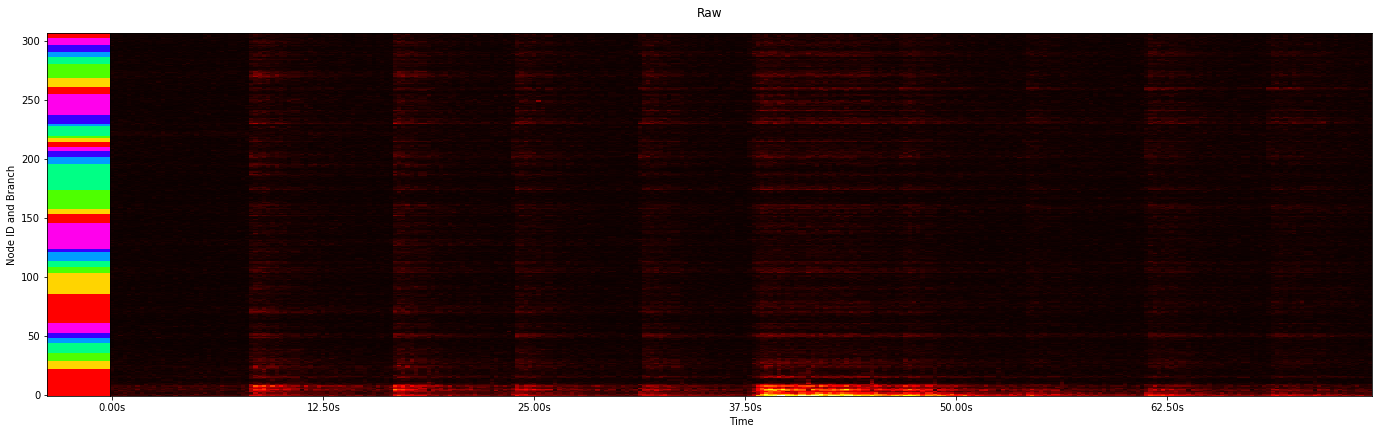

In [14]:
viz.plotIntensity(data, hz=HZ, branches=branchIDs, stim=stim, title="Raw")

In [15]:
dfofParams = (0.2, 0.75, 3.0)
dfof = deltaFOverF0(data, hz=HZ, t0=dfofParams[0], t1=dfofParams[1], t2=dfofParams[2])

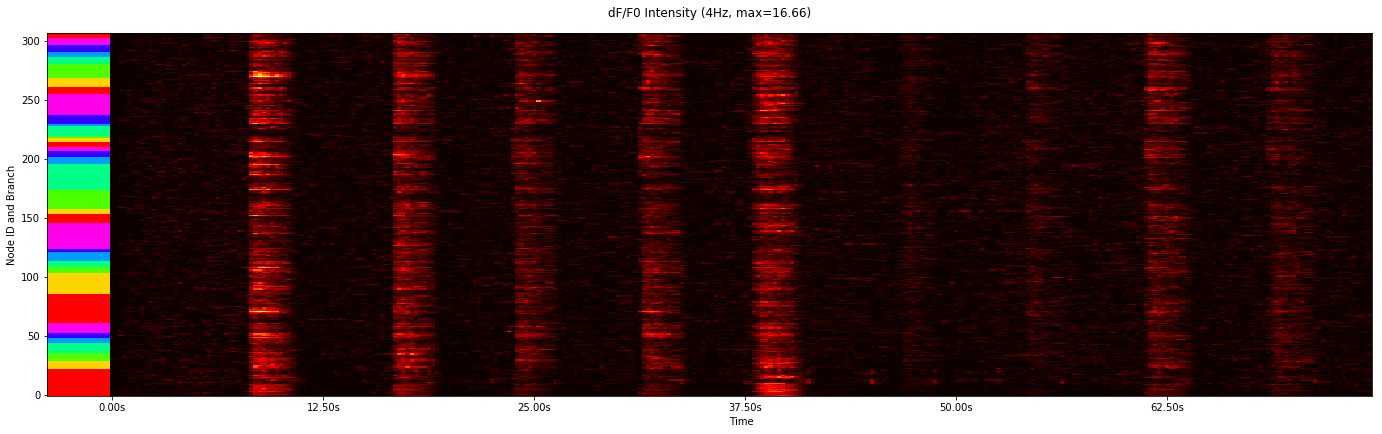

In [16]:
title = "dF/F0 Intensity (%dHz, max=%.2f)" % (HZ, np.nanmax(dfof))
viz.plotIntensity(dfof.clip(min=0), hz=HZ, branches=branchIDs, stim=stim, title=title)

In [9]:
if GENERATE_DFOF_ANIM: # or True:
    animPath = os.path.join(path, "raw_animation.mp4")
    aHz = HZ if HZ > 5 else HZ * 3
    xyOffset = (0, 0)
    # xyOffset = (-0.5, 0.5) # top Left
    viz.planarAnimation(tree, rootID, nodeXYZ, data, hz=aHz, stim=stim, savePath=animPath, stimXY=xyOffset)

In [10]:
if AV_STIM_INTENSITY:
    secAfter = 3
    first = 1
    stimOffIdx = stim[0+first:4+first, 0]
    stimOnIdx = stim[5+first:9+first, 0]
    viz.plotAveragePostStimIntensity(dfof, HZ, stimOffIdx, stimOnIdx, branches=branchIDs)

TypeError: 'NoneType' object is not subscriptable

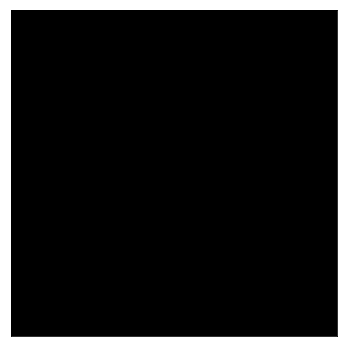

In [17]:
viz.debugPlotPlanar(tree, rootID, nodeXYZ, np.array(branchIDs))

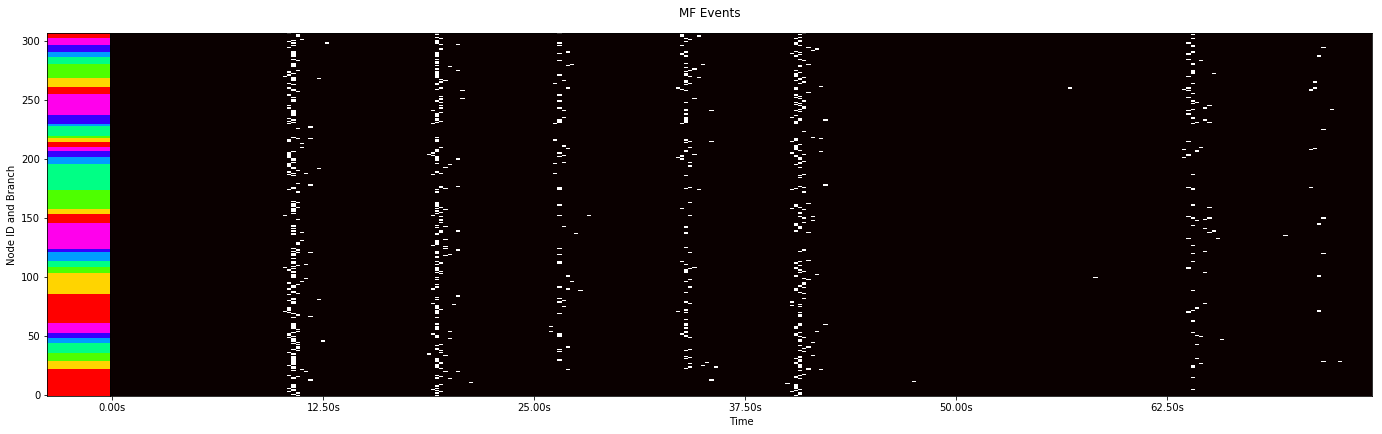

In [31]:
if EVENT_ALGO is not None:
    if EVENT_ALGO == 'MF':
        windowSize = 12
        threshold = 0
        metric = matchedFilter(dfof, HZ, windowSize, A=8.0)
        detect = thresholdEvents(metric, threshold)
        viz.plotIntensity(detect, hz=HZ, branches=branchIDs, stim=stim, title="MF Events")